In [63]:
# No need to run this anymore
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os
import sys
ROOT_DIR = "../"
sys.path.append(ROOT_DIR)
from utils.citymeta import load_all
city_meta = load_all()
# merge the lat lon for each city back to the df
city_meta['city_lower'] = city_meta['city_lower'].apply(lambda x: x.lower().replace(" ", "").split(",")[0])


In [65]:
ROOT = "/Users/yuan/Dropbox (Personal)/Personal Work/_Projects2023"
# ROOT = "D:/Dropbox (Personal)/Personal Work/_Projects2023"
CURATED_FOLDER = f"{ROOT}/01_city-never-was/_data/_curated"

EXPORT_FOLDER = f"{ROOT}/01_city-never-was/_data/_curated/c_analysis"
DATA_FOLDER = f"{CURATED_FOLDER}/c_seg_hex"
N = 8
CITY_LEVEL_FILE = f"c_city_full_cluster={N}.csv"
HEX_LEVEL_FILE = f"c_hex_full_cluster={N}.csv"

city_df = pd.read_csv(os.path.join(EXPORT_FOLDER, CITY_LEVEL_FILE))
hex_df = pd.read_csv(os.path.join(EXPORT_FOLDER, HEX_LEVEL_FILE))

In [43]:
hex_detail = pd.read_parquet(os.path.join(DATA_FOLDER, "c_seg_cat=31_res=9.parquet"))
hex_detail.head()

category,city_lower,hex_id,img_count,bike,building,bus,car,grass,ground,house,...,sportsfield,table+chair,tower,traffic light,trashcan,tree,truck,van,wall,window
0,accra,8975292c127ffff,20,28.700000,15701.5000,25.100000,4789.850000,213.300000,0.0,0.000000,...,0.00000,18.050000,0.0,0.0,22.850000,5621.900000,2563.850000,1130.700000,1790.600000,0.0
1,accra,8975292c803ffff,40,0.000000,10225.3750,0.000000,53.250000,126.950000,0.0,252.300000,...,11.55000,0.000000,0.0,2.8,5.700000,1641.025000,2.100000,0.000000,2986.350000,0.0
2,accra,8975292c80bffff,80,5.912500,11542.5125,0.000000,408.512500,247.675000,0.0,617.000000,...,18.50000,4.637500,0.0,0.0,0.000000,2151.100000,0.000000,1.550000,3035.787500,0.0
3,accra,8975292c817ffff,56,2.196429,8382.5000,43.410714,750.678571,621.946429,0.0,441.571429,...,519.87500,0.285714,0.0,0.0,0.285714,8563.303571,16.535714,8.071429,2723.321429,0.0
4,accra,8975292c81bffff,32,0.000000,10633.6250,0.000000,236.343750,0.031250,0.0,98.062500,...,22.90625,43.843750,0.0,0.0,0.937500,2864.250000,0.000000,0.000000,1709.625000,0.0


# 1. Viz structure

1. vizual cluster type of city (city-level)
2. sidewalk existance and road fatality measured by DALYs, road fatality per 100_000 person

In [66]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
# TESTING DIRECT CLUSTERING, NOT WORKING
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
def get_tsne(data, n_components=2):
    from sklearn import manifold
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

In [67]:
# use hierarchical cluster to group cities
variable_cols = ['cluster_0', 'cluster_1', 'cluster_10', 'cluster_11',
       'cluster_12', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5',
       'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9']
variable_cols_update = [x for x in variable_cols if x in city_df.columns]
X = city_df[variable_cols_update].values

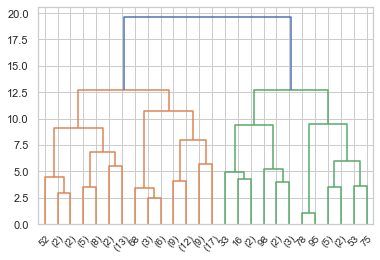

In [68]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)
model = model.fit(X_scale)
# visualize the clustering
plot_dendrogram(model, truncate_mode="level", p=4)

/Users/yuan/opt/anaconda3/envs/geo38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/yuan/opt/anaconda3/envs/geo38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


finish tsne


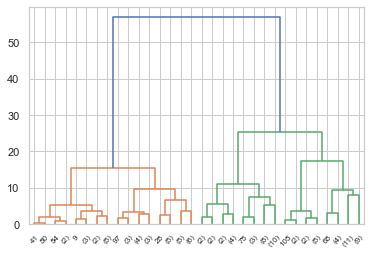

In [69]:
# OPTION 2: get tsne first then cluster.
tsne_data = get_tsne(X)  # this takes very long time.
print("finish tsne")
# save the tsne_data once done
tsne_df = pd.DataFrame(tsne_data, columns=["tsne_1", "tsne_2"]).reset_index(
    drop=True
)
tsne_df = pd.concat([city_df[['city_lower']], tsne_df], axis=1)

# fit the model and pick the cluster size
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(tsne_data)
# visualize the clustering
plot_dendrogram(model, truncate_mode="level", p=4)

In [70]:
N_CLUSTERS = 5
model = AgglomerativeClustering(n_clusters=N_CLUSTERS)
model = model.fit(tsne_data)
# plot_dendrogram(model, truncate_mode="level", p=6)
city_df_copy = tsne_df.copy()
city_df_copy['city_group'] = model.labels_
city_df_copy.groupby('city_group').size()
city_df['city_group'] = model.labels_



<AxesSubplot:xlabel='tsne_1', ylabel='tsne_2'>

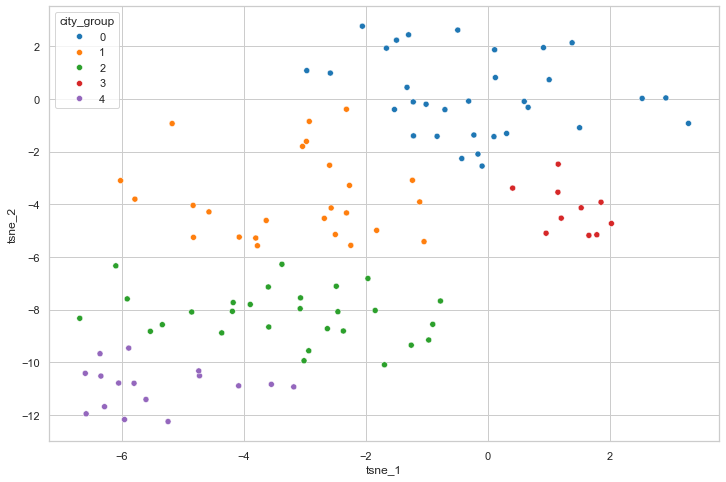

In [71]:
# visualize the tsne clustering
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.scatterplot(x="tsne_1", y="tsne_2", hue="city_group", data=city_df_copy, palette="tab10")

In [72]:
# check cluster and road fatality rate
def plt_variable(temp, target):

    temp[f'{target}_mean'] = temp.groupby('city_group')[target].transform('mean')
    temp = temp.sort_values(f'{target}_mean', ascending=False).reset_index(drop=True)
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    sns.boxplot(x="city_group", 
                y=target, 
                data=temp, 
                order=temp['city_group'].unique(),
                ax=ax)



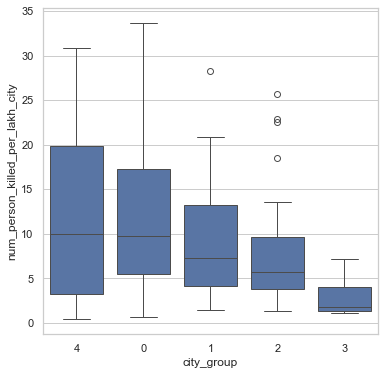

In [73]:
target = 'num_person_killed_per_lakh_city'
temp = city_df.copy()
plt_variable(temp, target)

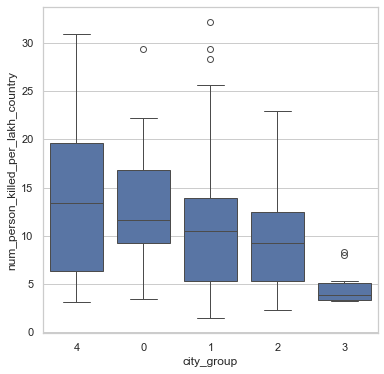

In [74]:
target = 'num_person_killed_per_lakh_country'
plt_variable(temp,target)

In [75]:
variables_sel_top1_order = [
    'skyscraper',
    'building',
    'house',
    'wall',
    'window',
    'road',
    'sidewalk',
    'traffic light',
    'trashcan',
    'railing',
    'light',
    'pole',
    'table+chair',
    'signage',
    'installation', 
    'sportsfield',
    'bike',
    'person',
    'bus',
    'truck',
    'van',
    'car',
    'grass',
    'shrub', 
    'tree',
    'lake+waterboday',
    'mountain+hill',
    'sky'
]
variables_available = [
    'building',
       'greenery', 
       'street_furniture', 
       'sidewalk', 
       'car', 
       'person', 
       'bike',
       'sky', 
       'road'
]

hex_detail = hex_detail[['city_lower', 'hex_id']+variables_sel_top1_order]
hex_detail['city_lower'] = hex_detail['city_lower'].apply(lambda x: x.lower().replace(" ", "").split(",")[0])
hex_df_cluster = hex_df.merge(
    city_df[['city_lower', 'city_group']], on='city_lower', how='inner'
).drop(variables_available, axis = 1)\
    .merge(hex_detail, on = ['city_lower', 'hex_id'], how='inner')

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5]),
 [Text(0.5, 1, 'skyscraper'),
  Text(1.5, 1, 'building'),
  Text(2.5, 1, 'house'),
  Text(3.5, 1, 'wall'),
  Text(4.5, 1, 'window'),
  Text(5.5, 1, 'road'),
  Text(6.5, 1, 'sidewalk'),
  Text(7.5, 1, 'traffic light'),
  Text(8.5, 1, 'trashcan'),
  Text(9.5, 1, 'railing'),
  Text(10.5, 1, 'light'),
  Text(11.5, 1, 'pole'),
  Text(12.5, 1, 'table+chair'),
  Text(13.5, 1, 'signage'),
  Text(14.5, 1, 'installation'),
  Text(15.5, 1, 'sportsfield'),
  Text(16.5, 1, 'bike'),
  Text(17.5, 1, 'person'),
  Text(18.5, 1, 'bus'),
  Text(19.5, 1, 'truck'),
  Text(20.5, 1, 'van'),
  Text(21.5, 1, 'car'),
  Text(22.5, 1, 'grass'),
  Text(23.5, 1, 'shrub'),
  Text(24.5, 1, 'tree'),
  Text(25.5, 1, 'lake+waterboday'),
  Text(26.5, 1, 'mountain+hill'),
  Text(27.5, 1, 'sky')])

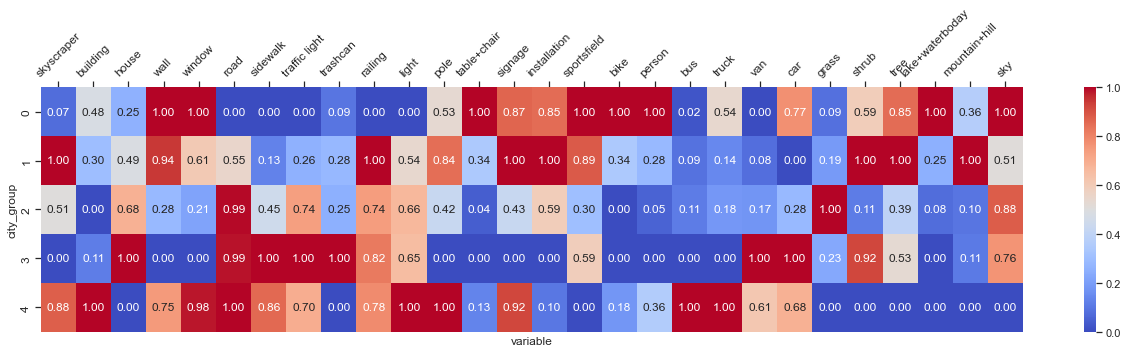

In [76]:
# make city_group level descriptive analysis
# summarize the cluster type
df_summary = hex_df_cluster[variables_sel_top1_order+["city_group"]].groupby("city_group").mean().stack().reset_index()\
.rename(columns = {"level_1":"variable", 0:"std_value"})


df_summary_update = []
for v in df_summary["variable"].unique():
    temp = df_summary[df_summary["variable"]==v].reset_index(drop = True)
    temp["norm_value"] = (temp["std_value"] - temp["std_value"].min())/(temp["std_value"].max() - temp["std_value"].min())
    df_summary_update.append(temp)
    
df_summary_update = pd.concat(df_summary_update).reset_index()

df_heat = df_summary_update.pivot(
    columns= "variable", values = "norm_value", index = "city_group"
)[variables_sel_top1_order]

# use heatmap to visualize the cluster
fig, ax = plt.subplots(figsize = (22,4.5))
# use a gradient color
sns.heatmap(df_heat, cmap = "coolwarm", annot = True, fmt=".2f", 
            ax = ax)
# show axis annotation larger
ax.tick_params(axis='both', which='major', labelsize=12)
# show ticks to the left
ax.yaxis.tick_left()
# show ticks to the bottom
ax.xaxis.tick_top()
# rotate the x axis
plt.xticks(rotation=45)

In [86]:
heat2 = city_df[['city_group']+variable_cols_update].groupby('city_group').mean()
heat2

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
city_group,,,,,,,,
0,0.106900,0.223427,0.118254,0.183509,0.015446,0.221997,0.091128,0.039338
1,0.063190,0.258339,0.118686,0.146403,0.003928,0.343662,0.040244,0.025547
2,0.058982,0.243376,0.046346,0.168297,0.003988,0.436420,0.029405,0.013186
3,0.040239,0.218230,0.049067,0.294077,0.003850,0.340177,0.039780,0.014580
4,0.076609,0.155224,0.064655,0.134239,0.002492,0.541976,0.018933,0.005871


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0.5, 1, 'cluster_0'),
  Text(1.5, 1, 'cluster_1'),
  Text(2.5, 1, 'cluster_2'),
  Text(3.5, 1, 'cluster_3'),
  Text(4.5, 1, 'cluster_4'),
  Text(5.5, 1, 'cluster_5'),
  Text(6.5, 1, 'cluster_6'),
  Text(7.5, 1, 'cluster_7')])

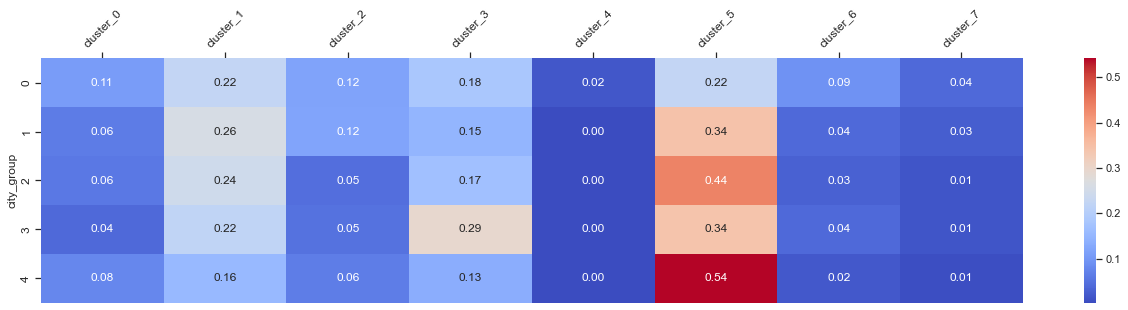

In [78]:


# use heatmap to visualize the cluster
fig, ax = plt.subplots(figsize = (22,4.5))
# use a gradient color
sns.heatmap(heat2, cmap = "coolwarm", annot = True, fmt=".2f", 
            ax = ax)
# show axis annotation larger
ax.tick_params(axis='both', which='major', labelsize=12)
# show ticks to the left
ax.yaxis.tick_left()
# show ticks to the bottom
ax.xaxis.tick_top()
# rotate the x axis
plt.xticks(rotation=45)

In [87]:
city_df_merge = city_df.merge(city_meta[['city_lower', 'center_lat', 'center_lng']], on='city_lower', how='inner')

In [50]:
# computer city level urban features.
hex_df_cluster.groupby('city_group')[variables_sel_top1_order].mean()

,skyscraper,building,house,wall,window,road,sidewalk,traffic light,trashcan,railing,...,bus,truck,van,car,grass,shrub,tree,lake+waterboday,mountain+hill,sky
city_group,,,,,,,,,,,,,,,,,,,,,
0,7.357450,11694.593056,1102.459494,1752.116515,3.918339,44399.875556,6199.202293,25.493785,61.791907,2352.107654,...,82.691289,287.043404,341.505269,3686.877350,4988.478127,2729.415838,20705.413259,302.966790,199.715456,51184.685630
1,25.908186,24879.918775,301.622550,4906.155035,12.493182,30795.574717,4491.062289,7.095423,27.671001,2309.201579,...,150.893922,564.476001,226.524467,3943.281203,2128.822960,4036.923527,21573.667105,2215.707512,472.390492,42199.524889
2,33.615253,23003.097666,126.836685,3347.132006,9.792243,45134.384765,6479.620793,23.312241,13.134318,2422.798867,...,208.043083,588.488605,268.830826,3920.317079,2774.478212,1998.070056,16426.904919,337.696382,196.781794,46827.085809
3,2.644148,13646.448676,640.545206,4184.204716,5.348542,35771.468347,3262.454422,9.077248,34.678968,1726.474742,...,55.874833,347.368360,169.442314,3664.150703,3564.736066,3177.627516,18272.405714,4727.660183,1250.557634,64254.113061
4,15.213275,16218.371759,506.636273,3699.099546,5.380748,39997.808701,3944.103997,16.068048,28.570120,2751.722216,...,106.350859,332.504203,238.247796,2613.404098,3107.980350,3330.272312,20618.591780,1213.540055,1080.048291,46587.611249
5,1.607284,10981.104940,260.547485,2532.366620,6.124595,33567.349833,3078.228968,10.284969,31.382993,2113.164004,...,75.270298,287.413078,150.812690,2496.155785,2932.746895,2559.345940,18662.018907,2848.394186,1224.485693,59689.252287


In [88]:
city_df_merge.to_csv(os.path.join(EXPORT_FOLDER, CITY_LEVEL_FILE.replace(".csv", f"_cluster={N}.csv")), index=False)
hex_df_cluster.to_csv(os.path.join(EXPORT_FOLDER, HEX_LEVEL_FILE.replace(".csv", f"_cluster={N}.csv")), index=False)
